In [1]:
# Import Packages
import glob  # OS dependencies to get file system details

import cv2
#importing some useful packages
import matplotlib.pyplot as plt
import numpy as np
import pickle
%matplotlib inline

In [2]:
def show_images(images, gray=None ):
    """
    This is an utility function to show multiple images with different colour maps

    :param images - An images list
    :param gray - A flag to set default value for matplotlib imshow colour map. If the image
                  shape is 2( i.e binary image) then cmap value will be "gray"
    :return: Nothing
    """
    rows = (len(images)+1)//4
    plt.figure(figsize=(15, 15))
    for idx, img in enumerate(images):
        plt.subplot(rows, 4,idx+1)
        # if the image is binary then it'll be printed as grayscale, otherwise colour map
        # will be ignored
        plt.imshow(img, cmap="gray" if len(img.shape) == 2 else gray)
        plt.xticks([])
        plt.yticks([])

    plt.show()


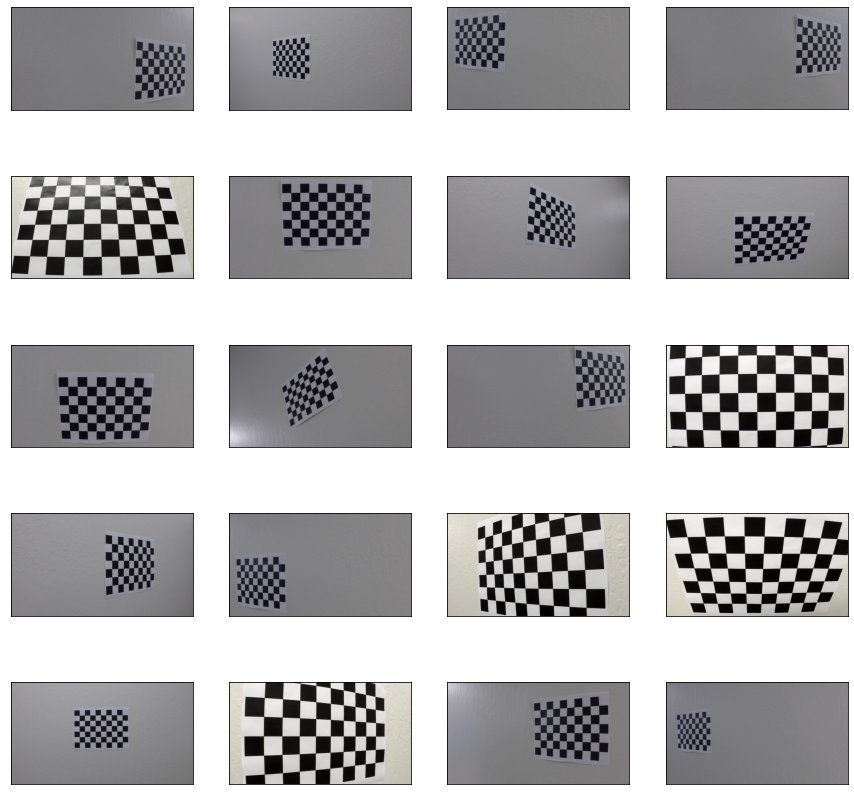

In [3]:
# Loading test images from test_image directory
test_images = [plt.imread(path) for path in glob.glob("camera_cal/*")]
# Visualize images
show_images(test_images)


#### Camera calibration

In [4]:
# Grayscale iamges - matplot reads
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [5]:
# prepare objects points
objp = np.zeros((6*8, 3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and iamg points from all the images
objpoints = []
imgpoints = []

def find_and_draw_corners(img,pttern_size=(8,6)):
    gray = grayscale(img)
    
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, pttern_size, None)
     # if found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw and display the corners
       drawChessboardCorners(img, pttern_size,corners, ret)
    

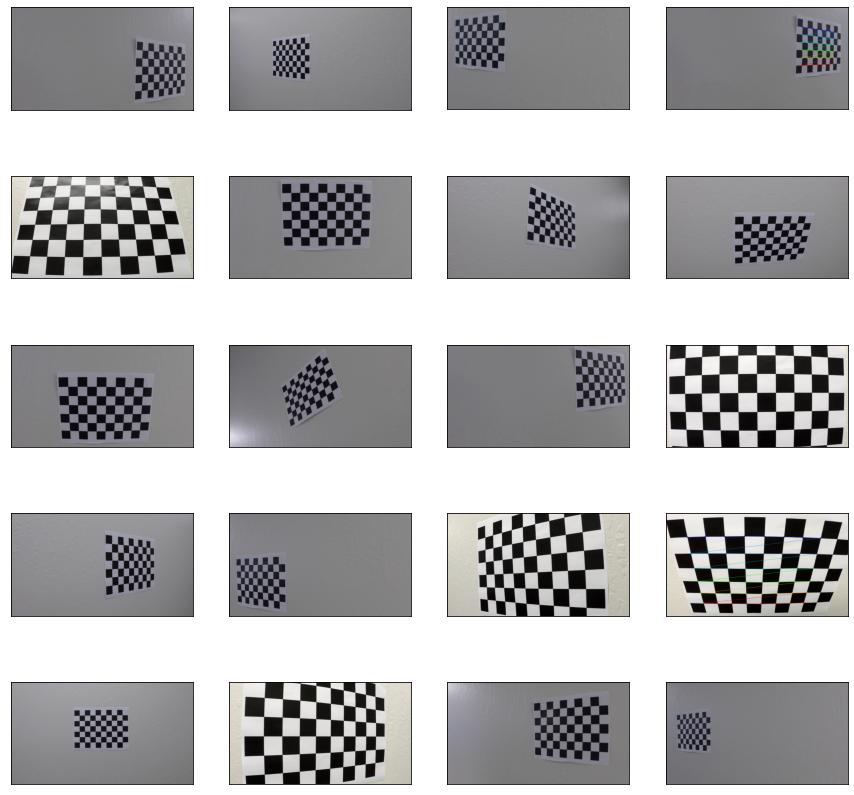

In [7]:
calibrated_images = list(map(lambda img: find_and_draw_corners(img),test_images ))
show_images(calibrated_images)